# Plot diagrams


In [83]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgba


from local_python.general_utils import (
    load_pd_from_json,
    select_and_sort_dataframe,
    check_duplicates,
)

In [84]:
path_f1_scores_grouped = "../results/f1_scores.csv"
architectures = ["ResNet50", "ViT_T16"]
x_axis_title = "N.o. samples per class"
selected_index = 0

In [85]:
selected_downstream = [
    "DDI",  # smallest derma dataset
    "PAD-UFES-20",
    "HAM10000",
    "Fitzpatrick17k",  # largest derma dataset
    "PlantDoc",  # smallest plant dataset
    "PlantDataset",
    "Cassava",
    "PlantVillage",  # largest plant dataset
][selected_index]

y_lims = [[0.3, 0.7], [0, 0.5], [0, 0.55], [0, 0.45], [0, 0.65], [0, 0.85], [0, 0.5], [0, 1]][selected_index]

In [86]:
def filter_and_unstack(df, filter_config):
    df_grouping_columns = [
        "pre-training",
        "number_of_samples",
    ]
    for filter_key, filter_list in filter_config.items():
        assert (
            filter_key in df.columns.values
        ), f"No column found with name {filter_key}"
        df = df[df[filter_key].isin(filter_list)]
    df = df[
        [
            "number_of_samples",
            "pre-training",
            "f1_macro_mean",
            "f1_macro_std",
            # "f1_macro_count",
        ]
    ]
    check_duplicates(df, df_grouping_columns)
    return df.set_index(df_grouping_columns).unstack(level=0).sort_index()

In [87]:
def get_architecture_confics(selected_architecture):
    colors = [
        "r",
        "b",
        "limegreen",
        "black",
        # "skyblue",
        # "m",
    ]
    column_labels = [
        "Dermatology SSL",
        "ImageNet SL/SSL",
        "Plant SL/SSL",
        "Random",
        # "ImageNet SSL",
        # "ImageNet SL",
        # "ImageNet AR",
    ]
    columns = []

    if "ResNet50" == selected_architecture:
        columns = [
            "Derma SSL ",
            "ImageNet SL ",
            "Plant SL",
            "Random",
            # "ImageNet_1k_SSL_SimCLR",
        ]
    elif "ViT_T16" == selected_architecture:
        columns = [
            "Derma SSL",
            "ImageNet SSL",
            "Plant SSL",
            "Random",
            # "ImageNet_1k_SL_WinKawaks",
            # "ImageNet_AugReg",
        ]
    else:
        print(f"Unknown architecture selected: {selected_architecture}")
    return colors, columns, column_labels

In [88]:
column_order_number_of_samples = ["1", "3", "10", "30", "100", "None"]

df_master = pd.read_csv(
    path_f1_scores_grouped,
    index_col=0,
    dtype={
        "number_of_samples": pd.CategoricalDtype(
            categories=column_order_number_of_samples, ordered=True
        )
    },
)
df_master.head(n=5)

,architecture,downstream,pre-training,number_of_samples,model_name,f1_macro_mean,f1_macro_std,f1_macro_count
0,ResNet50,Cassava,Derma SSL,1,dc,0.019217,0.000000,100
1,ResNet50,Cassava,Derma SSL,1,knn,0.184686,0.035744,100
2,ResNet50,Cassava,Derma SSL,1,lr,0.163515,0.045919,100
3,ResNet50,Cassava,Derma SSL,10,dc,0.019217,0.000000,100
4,ResNet50,Cassava,Derma SSL,10,knn,0.208679,0.018469,100


In [89]:
df_plot_1 = filter_and_unstack(
    df_master,
    {
        "number_of_samples": column_order_number_of_samples[:-1],
        "architecture": [architectures[0]],
        "model_name": ["knn"],
        "downstream": [selected_downstream],
    },
)
df_plot_2 = filter_and_unstack(
    df_master,
    {
        "number_of_samples": column_order_number_of_samples[:-1],
        "architecture": [architectures[0]],
        "model_name": ["lr"],
        "downstream": [selected_downstream],
    },
)
df_plot_3 = filter_and_unstack(
    df_master,
    {
        "number_of_samples": column_order_number_of_samples[:-1],
        "architecture": [architectures[0]],
        "model_name": ["dc"],
        "downstream": [selected_downstream],
    },
)

df_plot_4 = filter_and_unstack(
    df_master,
    {
        "number_of_samples": column_order_number_of_samples[:-1],
        "architecture": [architectures[1]],
        "model_name": ["knn"],
        "downstream": [selected_downstream],
    },
)
df_plot_5 = filter_and_unstack(
    df_master,
    {
        "number_of_samples": column_order_number_of_samples[:-1],
        "architecture": [architectures[1]],
        "model_name": ["lr"],
        "downstream": [selected_downstream],
    },
)
df_plot_6 = filter_and_unstack(
    df_master,
    {
        "number_of_samples": column_order_number_of_samples[:-1],
        "architecture": [architectures[1]],
        "model_name": ["dc"],
        "downstream": [selected_downstream],
    },
)

In [90]:
def plot_line_axis(ax, title, df_plot, legend_elements, architecture, baseline=False):
    colors, columns, column_labels = get_architecture_confics(architecture)
    for i, column in enumerate(columns):
        if baseline and 0 < i:
            break
        color = "k" if baseline else colors[i]
        label = "Baseline" if baseline else column_labels[i]
        linestyle = "--" if baseline else "-"
        edgecolor = to_rgba(color, alpha=0.6)

        mean_values = df_plot[("f1_macro_mean", column)].values
        std_values = df_plot[("f1_macro_std", column)].values

        if baseline:
            legend_elements[label] = Line2D(
                xdata=df_plot.index.values,
                ydata=df_plot.index.values,
                color=color,
                linestyle=linestyle,
                label=label,
            )
        else:
            facecolor = to_rgba(color, alpha=0.2)
            legend_elements[label] = Patch(
                facecolor=facecolor,
                edgecolor=edgecolor,
                label=label,
            )
            ax.fill_between(
                df_plot.index.values,
                mean_values - std_values,
                mean_values + std_values,
                facecolor=facecolor,
                label="_nolegend_",
            )
        ax.plot(
            df_plot.index.values,
            mean_values,
            label="_nolegend_",
            color=edgecolor,
            linestyle=linestyle,
        )
    stepsize = 0.1
    ax.set_ylim(y_lims)
    y_axis_title = "Macro F1 score"
    # ax.set_ylabel(y_axis_title)
    ax.set_xlabel(x_axis_title)
    ax.set_title(title)
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end + 0.001, stepsize))

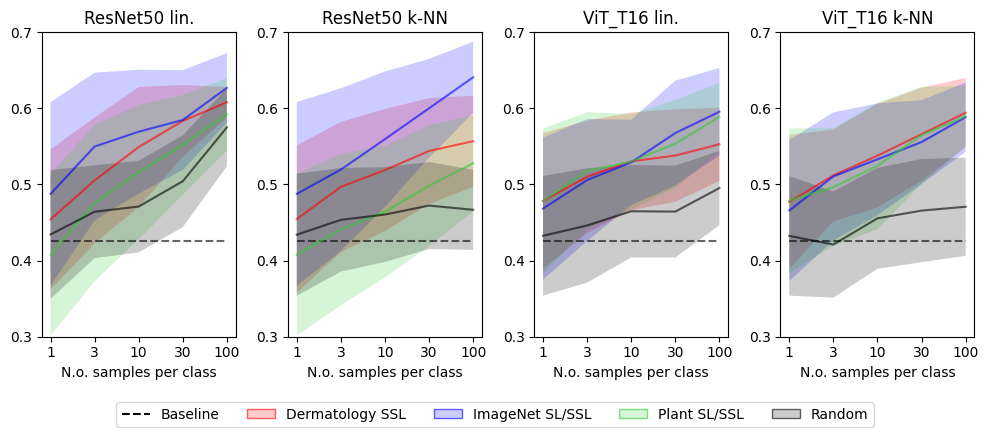

In [91]:
fig, axes = plt.subplots(
    figsize=(10, 4),
    nrows=1,
    ncols=4,
    squeeze=False,
)

legend_elements = {}
plot_line_axis(
    axes[0][0], "baseline", df_plot_3, legend_elements, architectures[0], baseline=True
)
plot_line_axis(
    axes[0][1], "baseline", df_plot_3, legend_elements, architectures[0], baseline=True
)
plot_line_axis(
    axes[0][0], f"{architectures[0]} lin.", df_plot_2, legend_elements, architectures[0]
)
plot_line_axis(
    axes[0][1], f"{architectures[0]} k-NN", df_plot_1, legend_elements, architectures[0]
)

plot_line_axis(
    axes[0][2], "baseline", df_plot_6, legend_elements, architectures[1], baseline=True
)
plot_line_axis(
    axes[0][3], "baseline", df_plot_6, legend_elements, architectures[1], baseline=True
)
plot_line_axis(
    axes[0][2], f"{architectures[1]} lin.", df_plot_5, legend_elements, architectures[1]
)
plot_line_axis(
    axes[0][3], f"{architectures[1]} k-NN", df_plot_4, legend_elements, architectures[1]
)

fig.tight_layout()
fig.legend(
    handles=list(legend_elements.values()),
    loc="upper center",
    bbox_to_anchor=(0.5, 0),
    ncol=len(legend_elements),
)
postfix = selected_downstream.lower().replace(" ", "_")
plt.savefig(f"../images/lines_{postfix}.png", bbox_inches="tight")